In [128]:
import numpy as np
import matplotlib.pyplot as plt


In [129]:

sigma=10.0
b=8.0/3.0
r=28.0

def Lorenz_derivatives(t,state):
    X,Y,Z=state
    dXdt=sigma*(Y-X)
    dYdt=-X*Z+r*X-Y
    dZdt=X*Y-b*Z
    return np.array([dXdt,dYdt,dZdt])

In [130]:
class RK45Integration:
    #Dormand-Prince parameters for embedded Runge-Kutta method. See Numerical Recipies 
    #chapter 17.2 for naming convention.
    a2 = np.array([1./5.])
    a3 = np.array([3./40., 9./40.])
    a4 = np.array([44./45., -56./15., 32./9.])
    a5 = np.array([19372./6561., -25360./2187., 64448./6561., -212./729.])
    a6 = np.array([9017./3168., -355./33., 46732./5247., 49./176., -5103./18656.])
    a = [a2, a3, a4, a5, a6]
    #
    c = np.array([1./5., 3./10., 4./5., 8./9., 1.])
    #coefficients fifth-oder Runge-Kutta
    b5 = np.array([35./384., 0., 500./1113., 125./192., -2187./6784., 11./84.])
    #coefficients fourth-order Runge-Kutta
    b4 = np.array([5179./57600., 0., 7571./16695., 393./640., -92097./339200., 187./2100.])
    #
    def __init__(self, derivatives, y0, x0, x1, h0, atol, rtol):
        #set initial values and step size
        self.y, self.h = y0, h0
        #set integration interval
        self.x, self.x1 = x0, x1
        #absolute and relative tolerance
        self.atol, self.rtol = atol, rtol
        #derivatives must be callable with signature f(x, y), where x is scalar and y = (X,Y,Z) an array. 
        #This function describes right-hand side of the differential equation.
        self.derivatives = derivatives
        #safeguard to prevent infinite loop in erroneous adaptive step size integration
        self.MAXSTEP = 1000001
        #parameters of step size control
        self.adaptiveSteps, self.alpha, self.safe, self.maxHincrease, self.maxHdecrease, self.lastRejected = True, 0.2, 0.95, 10., 0.2, True
        #computed trajectory
        self.xSave, self.ySave = [x0], [y0]
    #
    def dy(self, h):
        '''Performs one Runge-Kutte 5 integration with the given step size h. The incremented function values and the estimation of \
        the truncation error are returned as yout, yerr.'''
        k1=h*self.derivatives(self.x,self.y)
        k2=h*self.derivatives(self.x+self.c[0]*h,self.y+a[0]*k1)
        k3=h*self.derivatives(self.x+c[1]*h,self.y+np.dot(self.a[1],[k1,k2]))
        k4=h*self.derivatives(self.x+c[2]*h,self.y+np.dot(self.a[2],[k1,k2,k3]))
        k5=h*self.derivatives(self.x+c[3]*h,self.y+np.dot(self.a[3],[k1,k2,k3,k4]))
        k6=h*self.derivatives(self.x+c[4]*h,self.y+np.dot(self.a[4],[k1,k2,k3,k4,k5]))
        
        yout=self.y+np.dot(self.b5,[k1,k2,k3,k4,k5,k6])
        yerr=np.dot(self.b4-self.b5,[k1,k2,k3,k4,k5,k6])
        return yout,yerr
        
        
    #
    def step(self):
        '''Attempts a RK5 integration with the current step size h. The step size is adapted to meet the required accuracy and the \
        integration is repeated if necessary.'''
        N=(self.x1-self.x)/self.h
        for n in range(0,int(N)):
            yout,yerr=self.dy(self.h)
            self.y=yout
            self.xSave.append(self.x)
            self.ySave.append(self.y)
            self.x=self.x+self.h
            err = np.linalg.norm(yerr)
#        if err<self.atol:
#            print(" accuracy is meet")

#        else:
#            self.h=self.h/2.0
            
        
    #
    def integrate(self):
        '''Performs integration steps until the upper integration interval x1 has been reached.'''
        while self.x<self.x1:
            self.step()
        
    #
    def error(self, yout, yerr):
        '''Compute norm of scaled error estimate.'''
        return np.linalg.norm(yerr)
        
    #
    def checkStepsize(self, error):
        ''''Returns True if the error smaller than 1 and increases or reduces the stepsize correspondingly.'''

    #
    def getTrajectory(self):
        '''Convenience function to return trajectory as numpy arrays.'''
        return np.array(self.xSave), np.stack(self.ySave, axis=1)

In [131]:
initial_state=[2.0,3.0,14.0]
t_start=0.0
t_end=50.0
h=0.01
atol=1e-6
rtol=1e-6

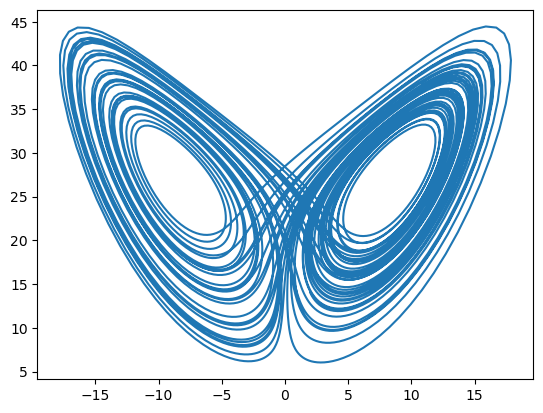

In [132]:

rk45_integrator = RK45Integration(derivatives=Lorenz_derivatives,y0=initial_state,x0=t_start,x1=t_end,h0=h,atol=atol,rtol=rtol)
rk45_integrator.step()
x_trajectory, y_trajectory = rk45_integrator.getTrajectory()

plt.plot(y_trajectory[0],y_trajectory[2])


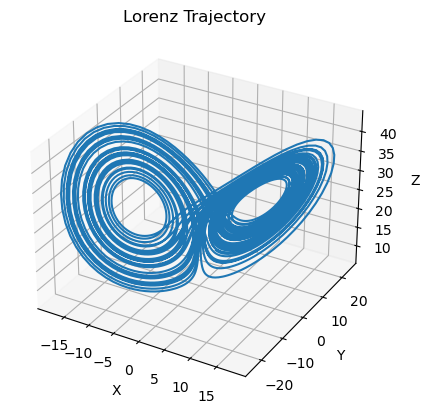

In [133]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(y_trajectory[0], y_trajectory[1], y_trajectory[2])
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('Lorenz Trajectory')
plt.show()